# ỨNG DỤNG NEURAL NETWORK TRONG NHẬN DIỆN ẢNH. (Không có hidden layer)

Yêu cầu:
- dataset: là một tập ảnh có mèo và không có mèo, một tập ảnh được gán nhãn (y=0) không có, (y=1) là có.
- Xây dựng một thuật toán nhận diện ảnh có mèo hay không có mèo bằng mô hình neural netwok không có lớp ẩn.
- Hàm kích hoạt là hàm: sigmoid.

Cài đặt thư viện và gọi dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import h5py
import scipy
from PIL import Image
from scipy import ndimage


## Hàm load dữ liệu

In [2]:
def load_dataset():
    train_dataset = h5py.File('./data/cat/train_catvnoncat.h5', "r")
    X_train = np.array(train_dataset["train_set_x"][:])
    y_train = np.array(train_dataset["train_set_y"][:])
    
    test_dataset = h5py.File('./data/cat/test_catvnoncat.h5', "r")
    X_test = np.array(test_dataset["test_set_x"][:])
    y_test = np.array(test_dataset["test_set_y"][:])
    
    classes = np.array(train_dataset["list_classes"][:])
    
    y_train = y_train.reshape((1, y_train.shape[0]))
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return X_train, y_train, X_test, y_test, classes

X_train, y_train, X_test, y_test, classes = load_dataset()

Xem dữ liệu, kiểm tra các chiều của dữ liệu. Xét một số bức ảnh trong dataset

[0]cat


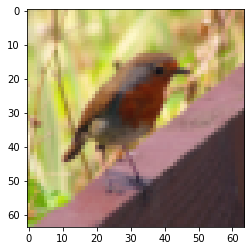

In [3]:
index = 10
plt.imshow(X_train[index])
print(str(y_train[:,index])+"cat")

[1]cat


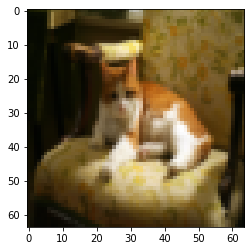

In [4]:
index = 7
plt.imshow(X_train[index])
print(str(y_train[:,index])+"cat")

In [5]:
print(X_train.shape)
print(X_test.shape)
num_train, heigt_train, weight_train, dimen1 = X_train.shape
num_test, heigt_test, weight_test, dimen2 = X_test.shape



(209, 64, 64, 3)
(50, 64, 64, 3)


Đưa, duỗi dữ liệu train và dữ liệu test từ mỗi ảnh có kích thước `(64,64,3)`, trải phẳng về một vecto có kích thước `(64*64*3,1)`

In [6]:
X_train_flatten = X_train.reshape(-1,X_train.shape[0])
print(X_train_flatten.shape)
X_test_flatten = X_test.reshape(-1,X_test.shape[0])
print(X_test_flatten.shape)

(12288, 209)
(12288, 50)


Chuẩn hóa dữ liệu, cuối cùng ta được tập X_train, X_test (chuẩn hóa chia mỗi pixel cho giá trị `255`)

In [7]:
X_train = X_train_flatten/ 255
X_test =  X_test_flatten/255
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12288, 209)
(12288, 50)
(1, 209)
(1, 50)


<img src="./logistic.png"/>

## Xây dựng mạng neuron .

1. Xác định kiến trúc của mô hình: số đặc trưng đầu vào, số kết quả đầu ra, cấu trúc của mỗi lớp, số lượng tham số,...
2. Khởi tạo giá trị ban đầu của các tham số của mô hình.
3. Vòng lặp:
      + Tính hàm loss (lan truyền thẳng).
      + Tính gradient dựa trên giá trị hàm loss.
      + Cập nhật giá trị cho các tham số gradient tính được.
4. Xây dựng các bước độc lập, tổng hợp thành `model()`.

## Hàm sigmoid (hàm kích hoạt)

In [8]:
def sigmoid(z):
    
    return 1/(1+np.exp(-z))
#test
print(sigmoid(np.array([-10, 0, 50])))

[4.53978687e-05 5.00000000e-01 1.00000000e+00]


## Khởi tạo ma trận trọng số W và bias

In [9]:
def mlp_init(d0):
    """
    W : matrix weight size (d0 = 64*64*3, 1)
    b : scalar bias
    """
    W = np.zeros((d0, 1))
    b = 0
    
    return W, b
#test
W_1, b_1 = mlp_init(2)
print("W_1:\n",W_1)
print("b_1:\n",b_1)

W_1:
 [[0.]
 [0.]]
b_1:
 0


## Hàm dự đoán

In [10]:
def mlp_predict(X, W, b):
    """
    X: matrix data size (64*64*3, number_example)
    W: matrix weight size (64*64*3, 1)
    b: bias scalar
    y_predict : (1, 209) = (1 , 64*64*3) * (64*64*3 , 209)
    """
    m = X.shape[1]  
    y_predict = np.zeros((1, m)) 
    W = W.reshape((X.shape[0],1))
    Z1 = np.dot(W.T,X) + b        # Z1,A1 size (1,209)
    A1 = sigmoid(Z1)
    for i in range(A1.shape[1]):
        y_predict[A1 <= 0.5] = 0
        y_predict[A1 > 0.5] = 1
    
    return y_predict
# test 
W_1, b_1 = mlp_init(64*64*3)
print(mlp_predict(X_train, W_1, b_1).shape)

(1, 209)


## Lan truyền tiến và lan truyền ngược 

In [11]:
def mlp_propagate(X, y, W, b):
    """
    X: matrix data size (64*64*3, number_examples = 209)
    y : label data size (1, number_examples = 209)
    W : matrix weigth size (64*64*3 , 1)
    b: bias (scalar)
    """
    m = X.shape[1]
    Z1 = np.dot(W.T, X) + b
    A1 = sigmoid(Z1)
    cost = -np.sum(y*np.log(A1)+(1-y)*np.log(1-A1))/m
    dW = -np.dot(X,(y-A1).T)/m
    db = -np.sum(y-A1)/m
    
    grads = {"dW":dW, "db":db}
    return grads, cost
#test
W_1, b_1 = mlp_init(64*64*3)
print(mlp_propagate(X_train, y_train, W_1, b_1))

({'dW': array([[ 0.02329487],
       [ 0.02855803],
       [ 0.03176658],
       ...,
       [-0.        ],
       [-0.        ],
       [-0.        ]]), 'db': 0.15550239234449761}, 0.6931471805599453)


## Tối ưu sử dụng gradient descent

In [12]:
def mlp_op(X, y, W, b, num_iterations, learning_rate, print_cost = False):
    
    """
    X: matrix data size (64*64*3 ,num_examples = 209)
    y: label data siza (1, num_examples = 209)
    W: matrix weight (64*64*3, 1)
    b : bias
    """
    costs = []
    for i in range(num_iterations):
        grads, cost = mlp_propagate(X, y, W, b) 
        dW = grads["dW"]
        db = grads["db"]
        W = W - learning_rate * dW
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    params = {"W": W,
              "b": b}
    
    grads = {"dW": dW,
             "db": db}
    
    return params, grads, costs
#test 
print(mlp_op(X_train, y_train, W_1, b_1, num_iterations= 100, learning_rate = 0.009, print_cost = False))

({'W': array([[-0.00028538],
       [-0.00119413],
       [-0.00099453],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]]), 'b': -0.002812324791435732}, {'dW': array([[ 0.06058499],
       [ 0.06086015],
       [ 0.05808193],
       ...,
       [-0.        ],
       [-0.        ],
       [-0.        ]]), 'db': 0.37630310947701573}, [0.6931471805599453])


## Xây dựng model

In [13]:
def model(X_train, y_train, X_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    W, b = mlp_init(X_train.shape[0])
    parameters, grads, costs = mlp_op(X_train, y_train, W, b, num_iterations, learning_rate, print_cost)
    W = parameters["W"]
    b = parameters["b"]
    y_predict_train = mlp_predict(X_train, W, b)
    y_predict_test = mlp_predict(X_test, W, b)
    print("trainning accuracy:", 100*np.mean(y_predict_train == y_train), "%")
    print("test accuracy:", 100*np.mean(y_predict_test == y_test),"%")
    
    d = {"costs":costs,
         "y_predict_train": y_predict_train,
         "y_predict_test": y_predict_test,
         "W":W,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations
         }
    
    return d
    

In [14]:
d = model(X_train, y_train, X_test, y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.709726
Cost after iteration 200: 0.657712
Cost after iteration 300: 0.614611
Cost after iteration 400: 0.578001
Cost after iteration 500: 0.546372
Cost after iteration 600: 0.518331
Cost after iteration 700: 0.492852
Cost after iteration 800: 0.469259
Cost after iteration 900: 0.447139
Cost after iteration 1000: 0.426262
Cost after iteration 1100: 0.406617
Cost after iteration 1200: 0.388723
Cost after iteration 1300: 0.374678
Cost after iteration 1400: 0.365826
Cost after iteration 1500: 0.358532
Cost after iteration 1600: 0.351612
Cost after iteration 1700: 0.345012
Cost after iteration 1800: 0.338704
Cost after iteration 1900: 0.332664
trainning accuracy: 91.38755980861244 %
test accuracy: 34.0 %


In [15]:
print(d["W"].shape)

(12288, 1)


## Bình luận 

In [16]:
# Hàm chi phí
costs = np.squeeze(d["costs"])
print(costs)

[0.69314718 0.70972636 0.65771191 0.61461079 0.57800073 0.54637152
 0.51833124 0.49285151 0.46925927 0.44713858 0.42626228 0.40661657
 0.38872327 0.37467754 0.36582608 0.35853187 0.3516119  0.34501223
 0.33870439 0.33266414]


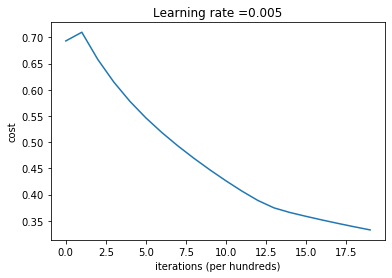

In [17]:
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Thay đổi learning_rate

learning_rates: 0.01
trainning accuracy: 73.68421052631578 %
test accuracy: 34.0 %
----------------------------------------------------
learning_rates: 0.005
trainning accuracy: 91.38755980861244 %
test accuracy: 34.0 %
----------------------------------------------------
learning_rates: 0.0001
trainning accuracy: 66.98564593301435 %
test accuracy: 34.0 %
----------------------------------------------------


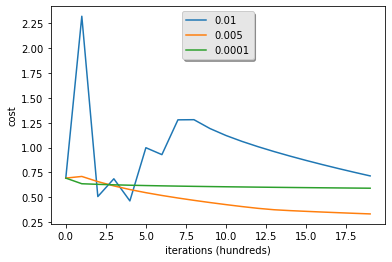

In [18]:
learning_rates = [0.01, 0.005, 0.0001]
models = {}
for i in learning_rates:
    print("learning_rates:",i)
    models[str(i)] = model(X_train, y_train, X_test, y_test, num_iterations = 2000, learning_rate = i, print_cost = False)
    print("----------------------------------------------------")
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]),label= str(models[str(i)]["learning_rate"]))

    
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()